In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import sys
import copy
import numpy as np
import pandas as pd
import sklearn
from sklearn import cluster, datasets, mixture
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from scipy.spatial import Voronoi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import seaborn as sns
from ExKMC.Tree import Tree as ExTree
from intercluster.rules import *
from intercluster.pruning import *
from intercluster.experiments import *
from intercluster import *

%load_ext autoreload
%autoreload 2

In [3]:
# NOTE: The following is important for recreating results, 
# But can be changed for randomized analysis.
seed = 170
np.random.seed(seed)

In [4]:
colorblind_palette = sns.color_palette("colorblind", as_cmap=False)
cmap = ListedColormap(colorblind_palette)
subset_colors = [cmap(0), cmap(4), cmap(9)]
cmap_subset = ListedColormap(subset_colors)
tab20 = plt.get_cmap('tab20')

palette = sns.color_palette("husl", 8)
cmap = ListedColormap(palette)

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 20
})

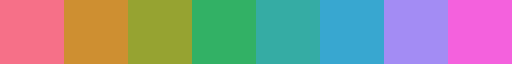

In [5]:
cmap

## Simple Dataset

In [6]:
n = 2000
m = 2
k = 3

random_state = 170
data, labels = datasets.make_blobs(
    n_samples=[1000,700,300], cluster_std=[1.0, 2.5, 0.5], random_state=seed
)
data = preprocessing.MinMaxScaler().fit_transform(data)

In [7]:
'''
n = 2000
m = 2
k = 5

random_state = 1711
data, labels = datasets.make_blobs(
    n_samples=n, centers = k, cluster_std=[1.0, 0.8, 1, 2, 1.2], random_state=random_state
)
data = preprocessing.MinMaxScaler().fit_transform(data)
'''

'\nn = 2000\nm = 2\nk = 5\n\nrandom_state = 1711\ndata, labels = datasets.make_blobs(\n    n_samples=n, centers = k, cluster_std=[1.0, 0.8, 1, 2, 1.2], random_state=random_state\n)\ndata = preprocessing.MinMaxScaler().fit_transform(data)\n'

Text(0, 0.5, 'y')

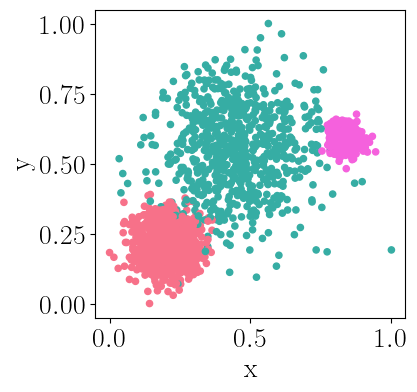

In [8]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
ax.scatter(data[:,0], data[:,1], c = labels, cmap = cmap, alpha = 1, s = 20)
ax.set_xlabel('x')
ax.set_ylabel('y')
#plt.savefig('figures/example_ground_truth.jpg', bbox_inches = 'tight', dpi = 300)

### Kmeans baseline

In [9]:
kmeans = KMeans(n_clusters=k, random_state=seed).fit(data)
kmeans_labels = labels_format(kmeans.labels_)
kmeans_assignment = labels_to_assignment(kmeans_labels, n_labels = k)
cost = kmeans_cost(data, kmeans.cluster_centers_, kmeans_assignment)

Text(0, 0.5, 'y')

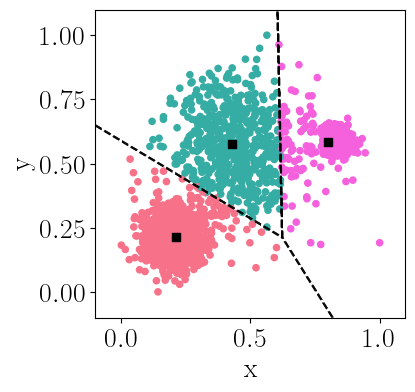

In [10]:
colorswitch = {0:2, 1:0, 2:1}
kmeans_labels_ = np.array([colorswitch[i] for i in kmeans.labels_])
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[:,0], data[:,1], c = kmeans_labels_, cmap = cmap, s = 20)
plot_decision_boundaries(kmeans, data, ax = ax, resolution = 1000, label_array = True)

plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c = 'k', s = 30, marker = 's')

#unique_labels = np.unique(kmeans.labels_)
#handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10, label=f'Cluster {label}') for label in unique_labels]

ax.set_xlabel('x')
ax.set_ylabel('y')
#plt.legend(handles=handles, loc = 'upper left')
#plt.savefig('figures/example_kmeans.jpg', bbox_inches = 'tight', dpi = 300)

# Generating Rules

### IMM / ExKMC

In [11]:
# As long as imm = True, ExkmcTree will produce an IMM tree if 
# given max_leaf_nodes = n_clusters.
exkmc_tree = ExkmcTree(
    k = k,
    kmeans = kmeans,
    max_leaf_nodes = 6,
    imm = True
)
exkmc_tree.fit(data)
exkmc_labels = exkmc_tree.predict(data, leaf_labels = False)
exkmc_label_array = flatten_labels(exkmc_labels)

Text(0, 0.5, 'y')

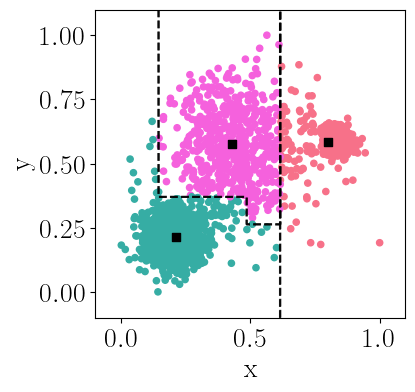

In [12]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
ax.scatter(data[:,0], data[:,1], c = exkmc_label_array, cmap = cmap, s = 20)
plot_decision_boundaries(exkmc_tree, data, ax = ax, resolution = 1000)

plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c = 'k', s = 30, marker = 's')

ax.set_xlabel('x')
ax.set_ylabel('y')
#plt.savefig('figures/example_imm.jpg', bbox_inches = 'tight', dpi = 300)

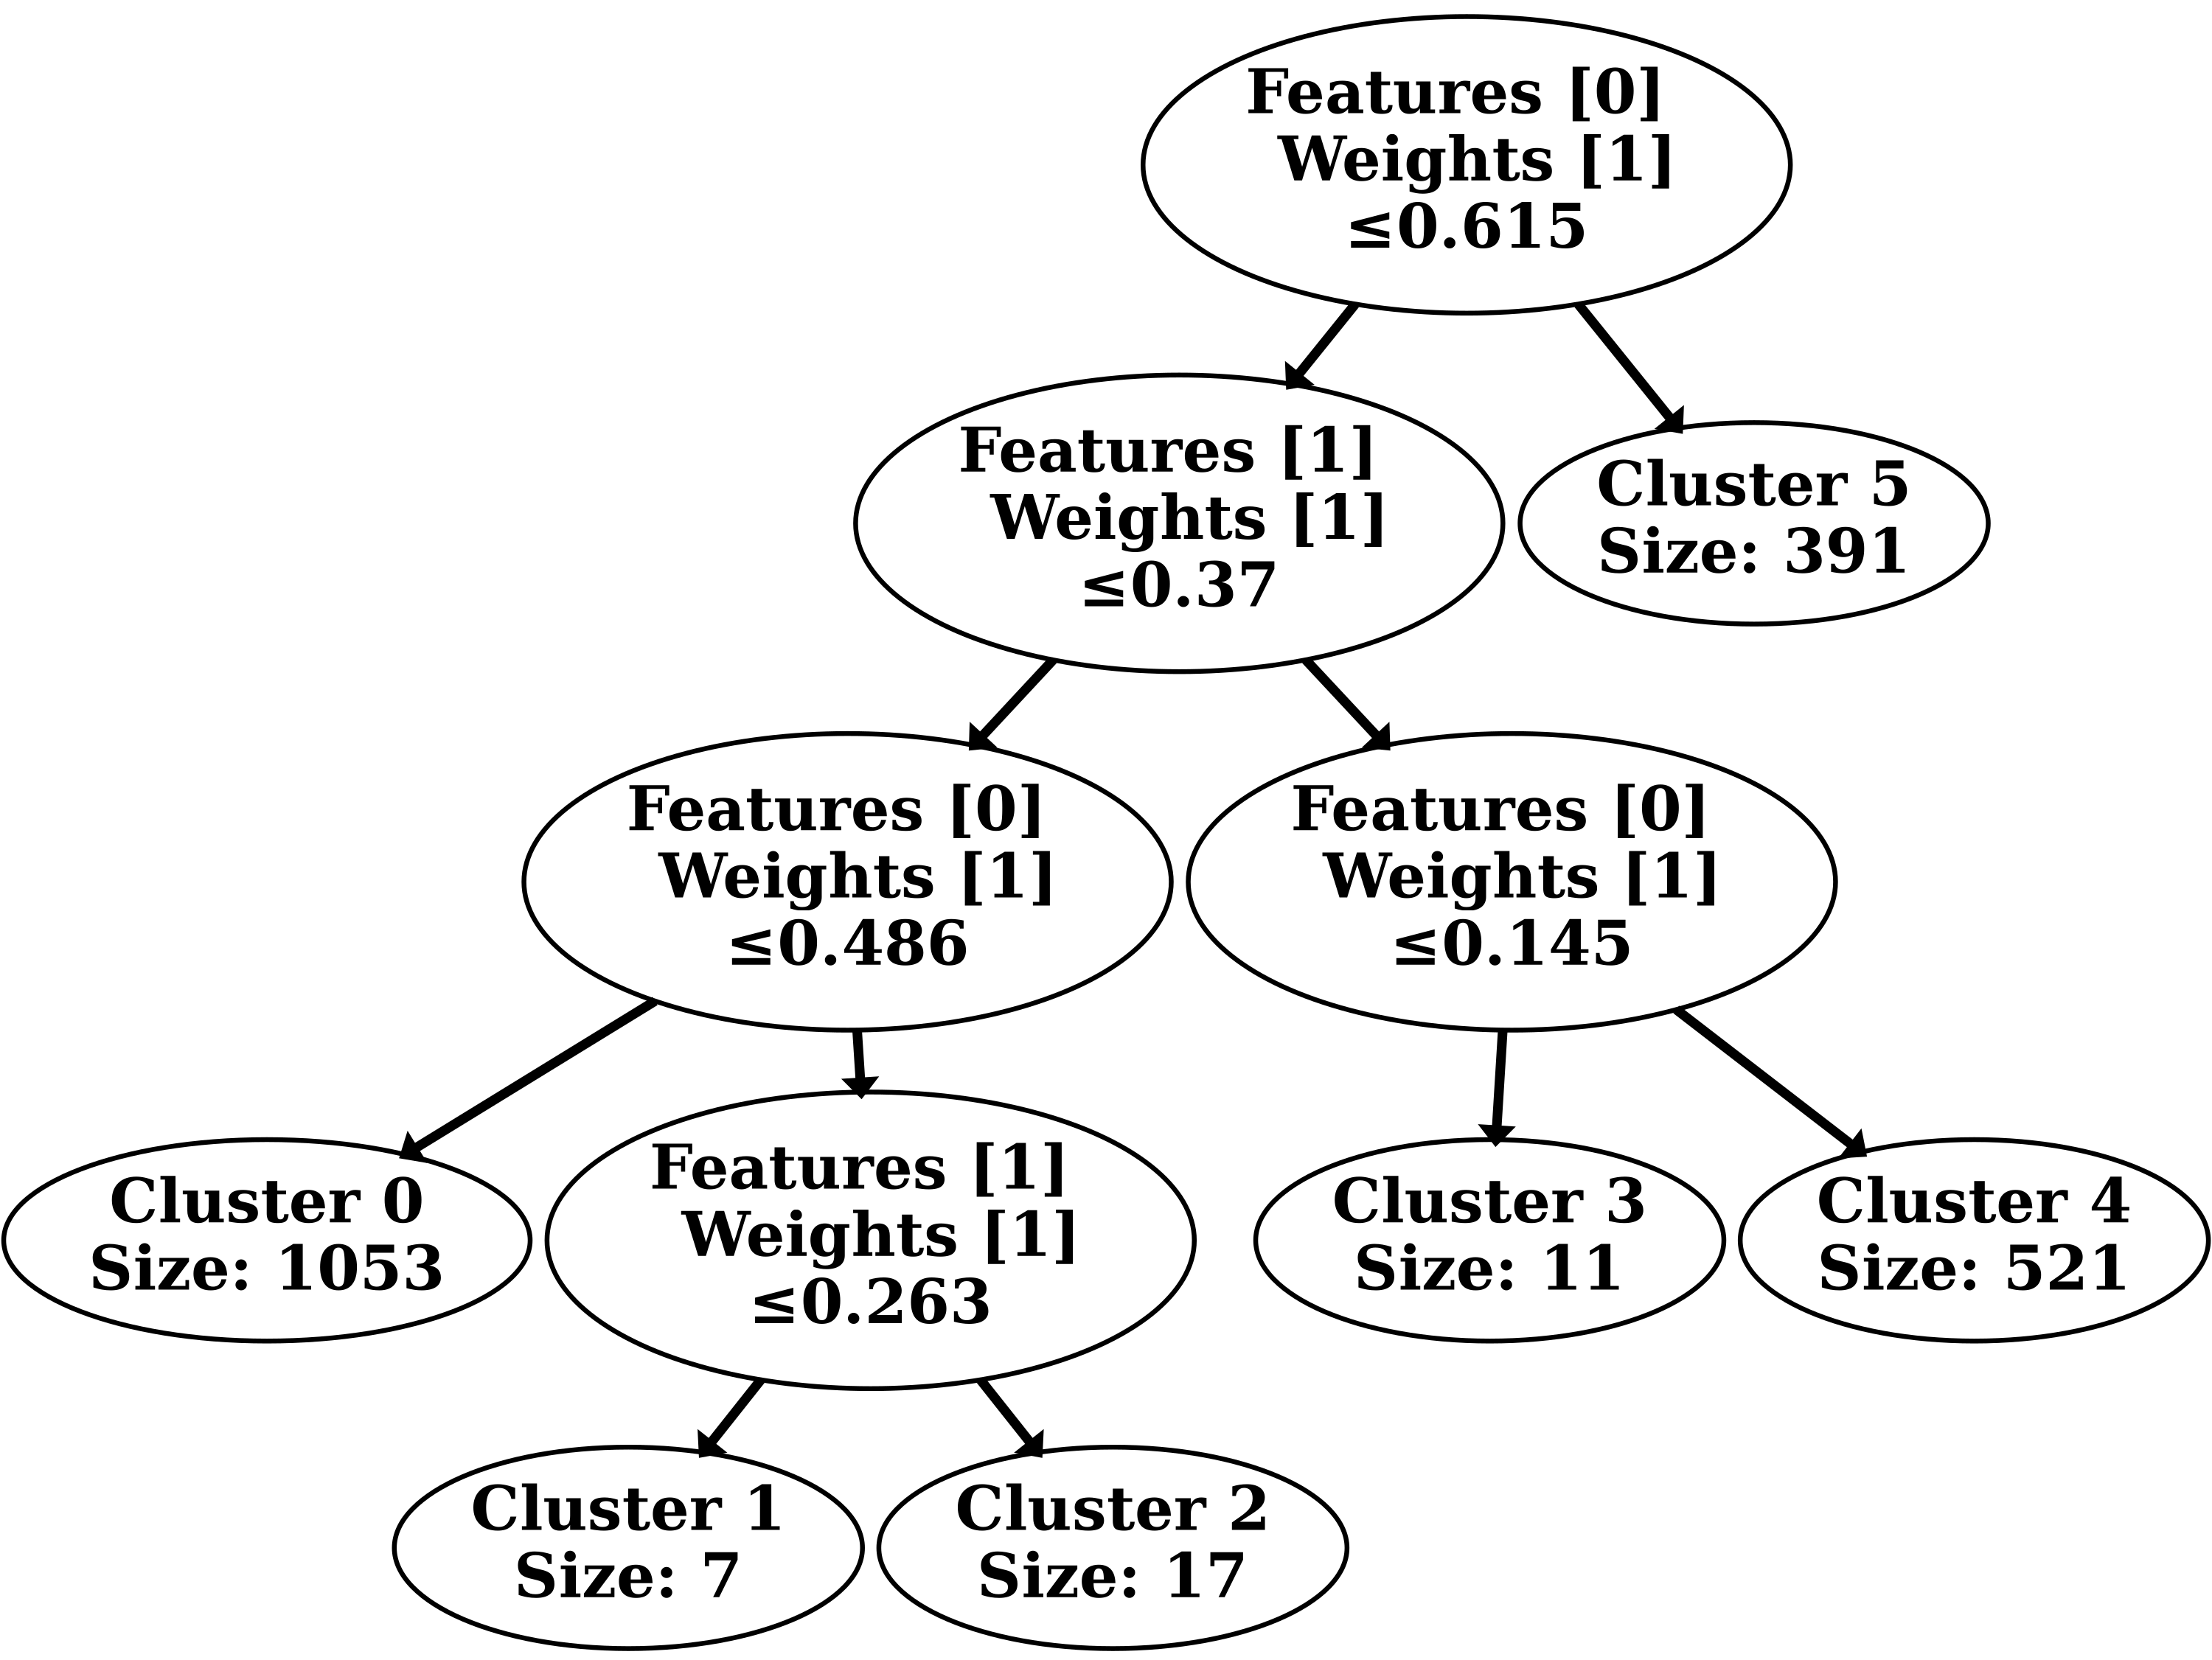

In [72]:
visualize_tree(exkmc_tree.root, cost = False)

### Decision Tree

In [13]:
data_labels = kmeans_labels
d_tree = SklearnTree(criterion = 'entropy', max_leaf_nodes = 6)
d_tree.fit(data, data_labels)
d_labels = d_tree.predict(data, leaf_labels = False)
d_label_array = flatten_labels(d_labels)

Text(0, 0.5, 'y')

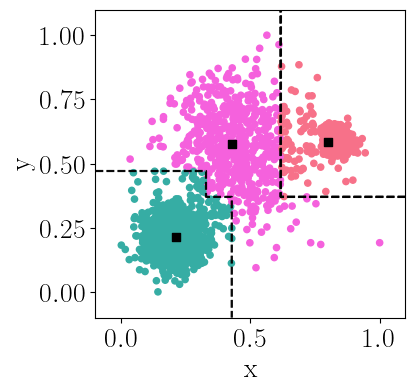

In [15]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[:,0], data[:,1], c = d_label_array, cmap = cmap, s = 20)
plot_decision_boundaries(d_tree, data, ax = ax, resolution = 1000)

plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c = 'k', s = 30, marker = 's')

ax.set_xlabel('x')
ax.set_ylabel('y')

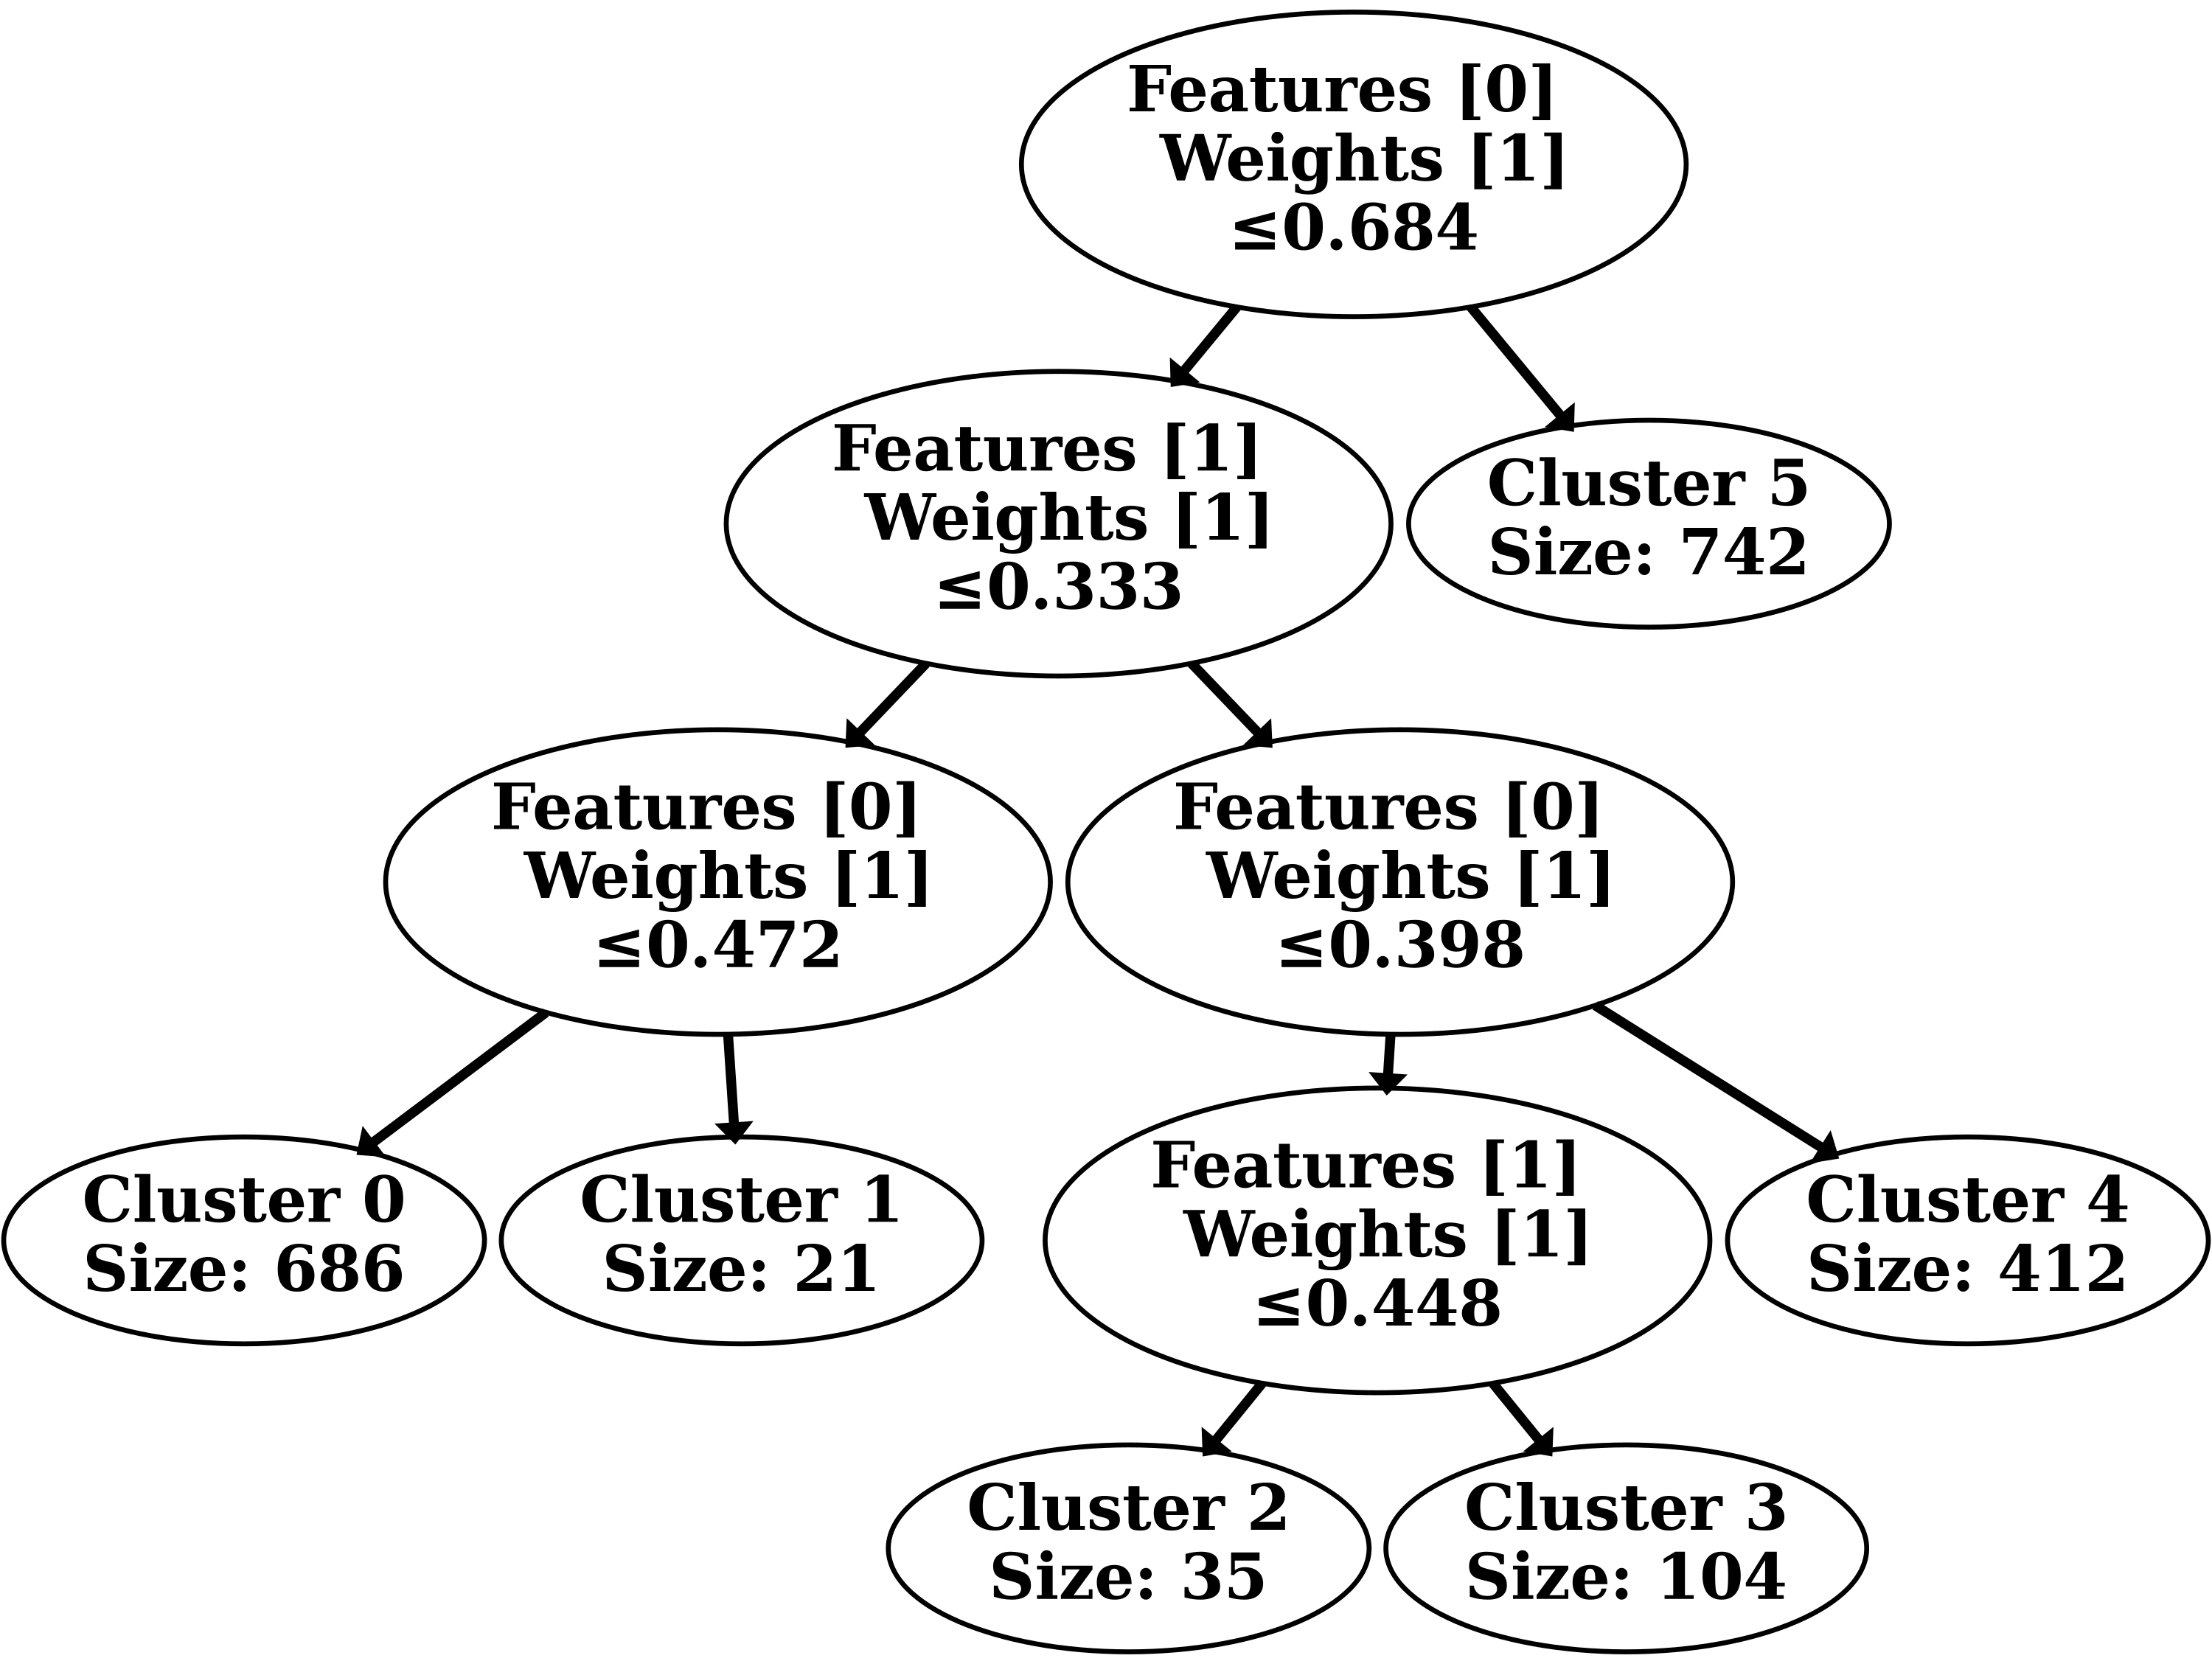

In [17]:
visualize_tree(d_tree.root, cost = False)

### Oblique Tree

In [16]:
import time
start = time.time()
data_labels = kmeans_labels
obl_tree = ObliqueTree(max_leaf_nodes = 6)
obl_tree.fit(data, data_labels)
obl_labels = obl_tree.predict(data)
obl_label_array = flatten_labels(obl_labels)
end = time.time()
print(end - start)

4.264801740646362


Text(0, 0.5, 'y')

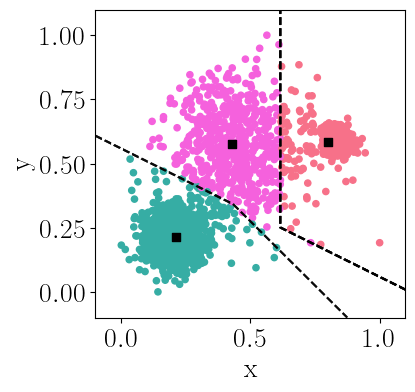

In [17]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[:,0], data[:,1], c = obl_label_array, cmap = cmap, s = 20)
plot_decision_boundaries(obl_tree, data, ax = ax, resolution = 1000)

plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c = 'k', s = 30, marker = 's')

ax.set_xlabel('x')
ax.set_ylabel('y')

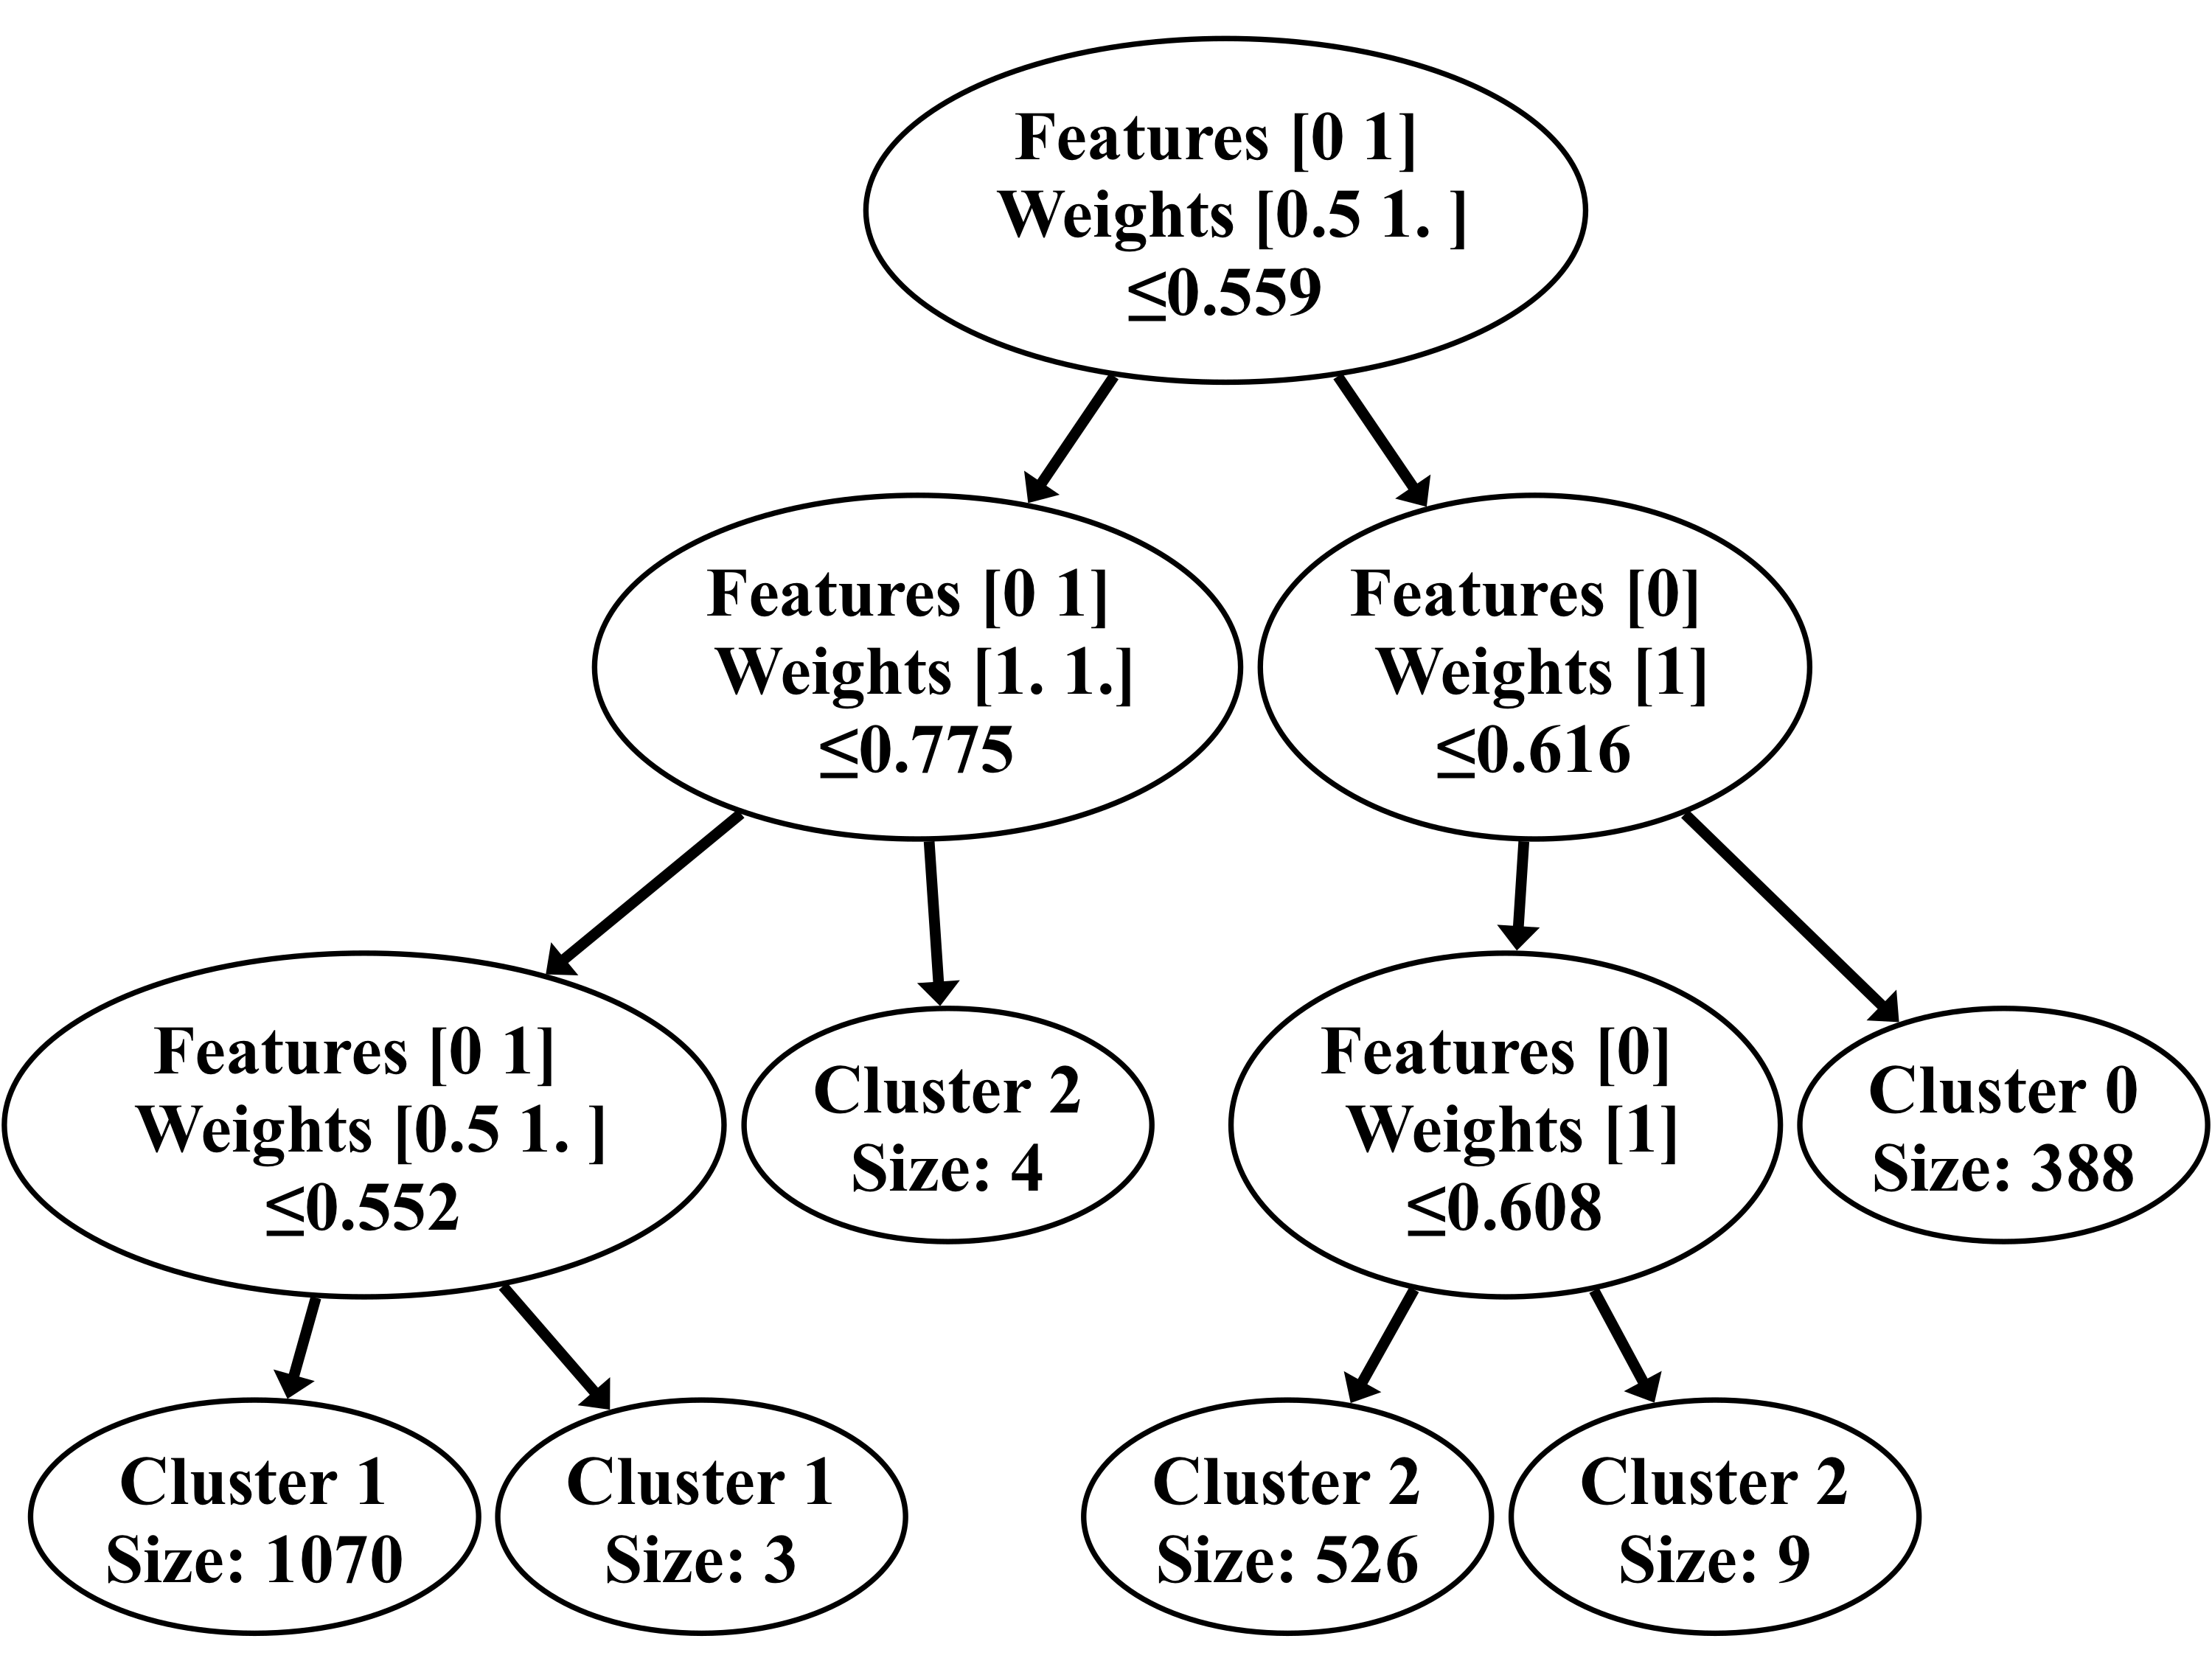

In [33]:
visualize_tree(obl_tree.root, cost = False)

### SVM Tree

In [19]:
target_cluster = 2
data_labels = labels_format((kmeans.labels_ == target_cluster).astype(int))
svm_tree = SVMTree()
svm_tree.fit(data, data_labels)
svm_labels = svm_tree.predict(data)
svm_label_array = flatten_labels(svm_labels)

Text(0, 0.5, 'y')

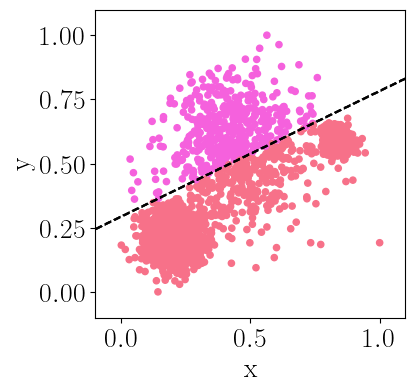

In [20]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[:,0], data[:,1], c = svm_label_array, cmap = cmap, s = 20)
plot_decision_boundaries(svm_tree, data, ax = ax, resolution = 1000)
ax.set_xlabel('x')
ax.set_ylabel('y')

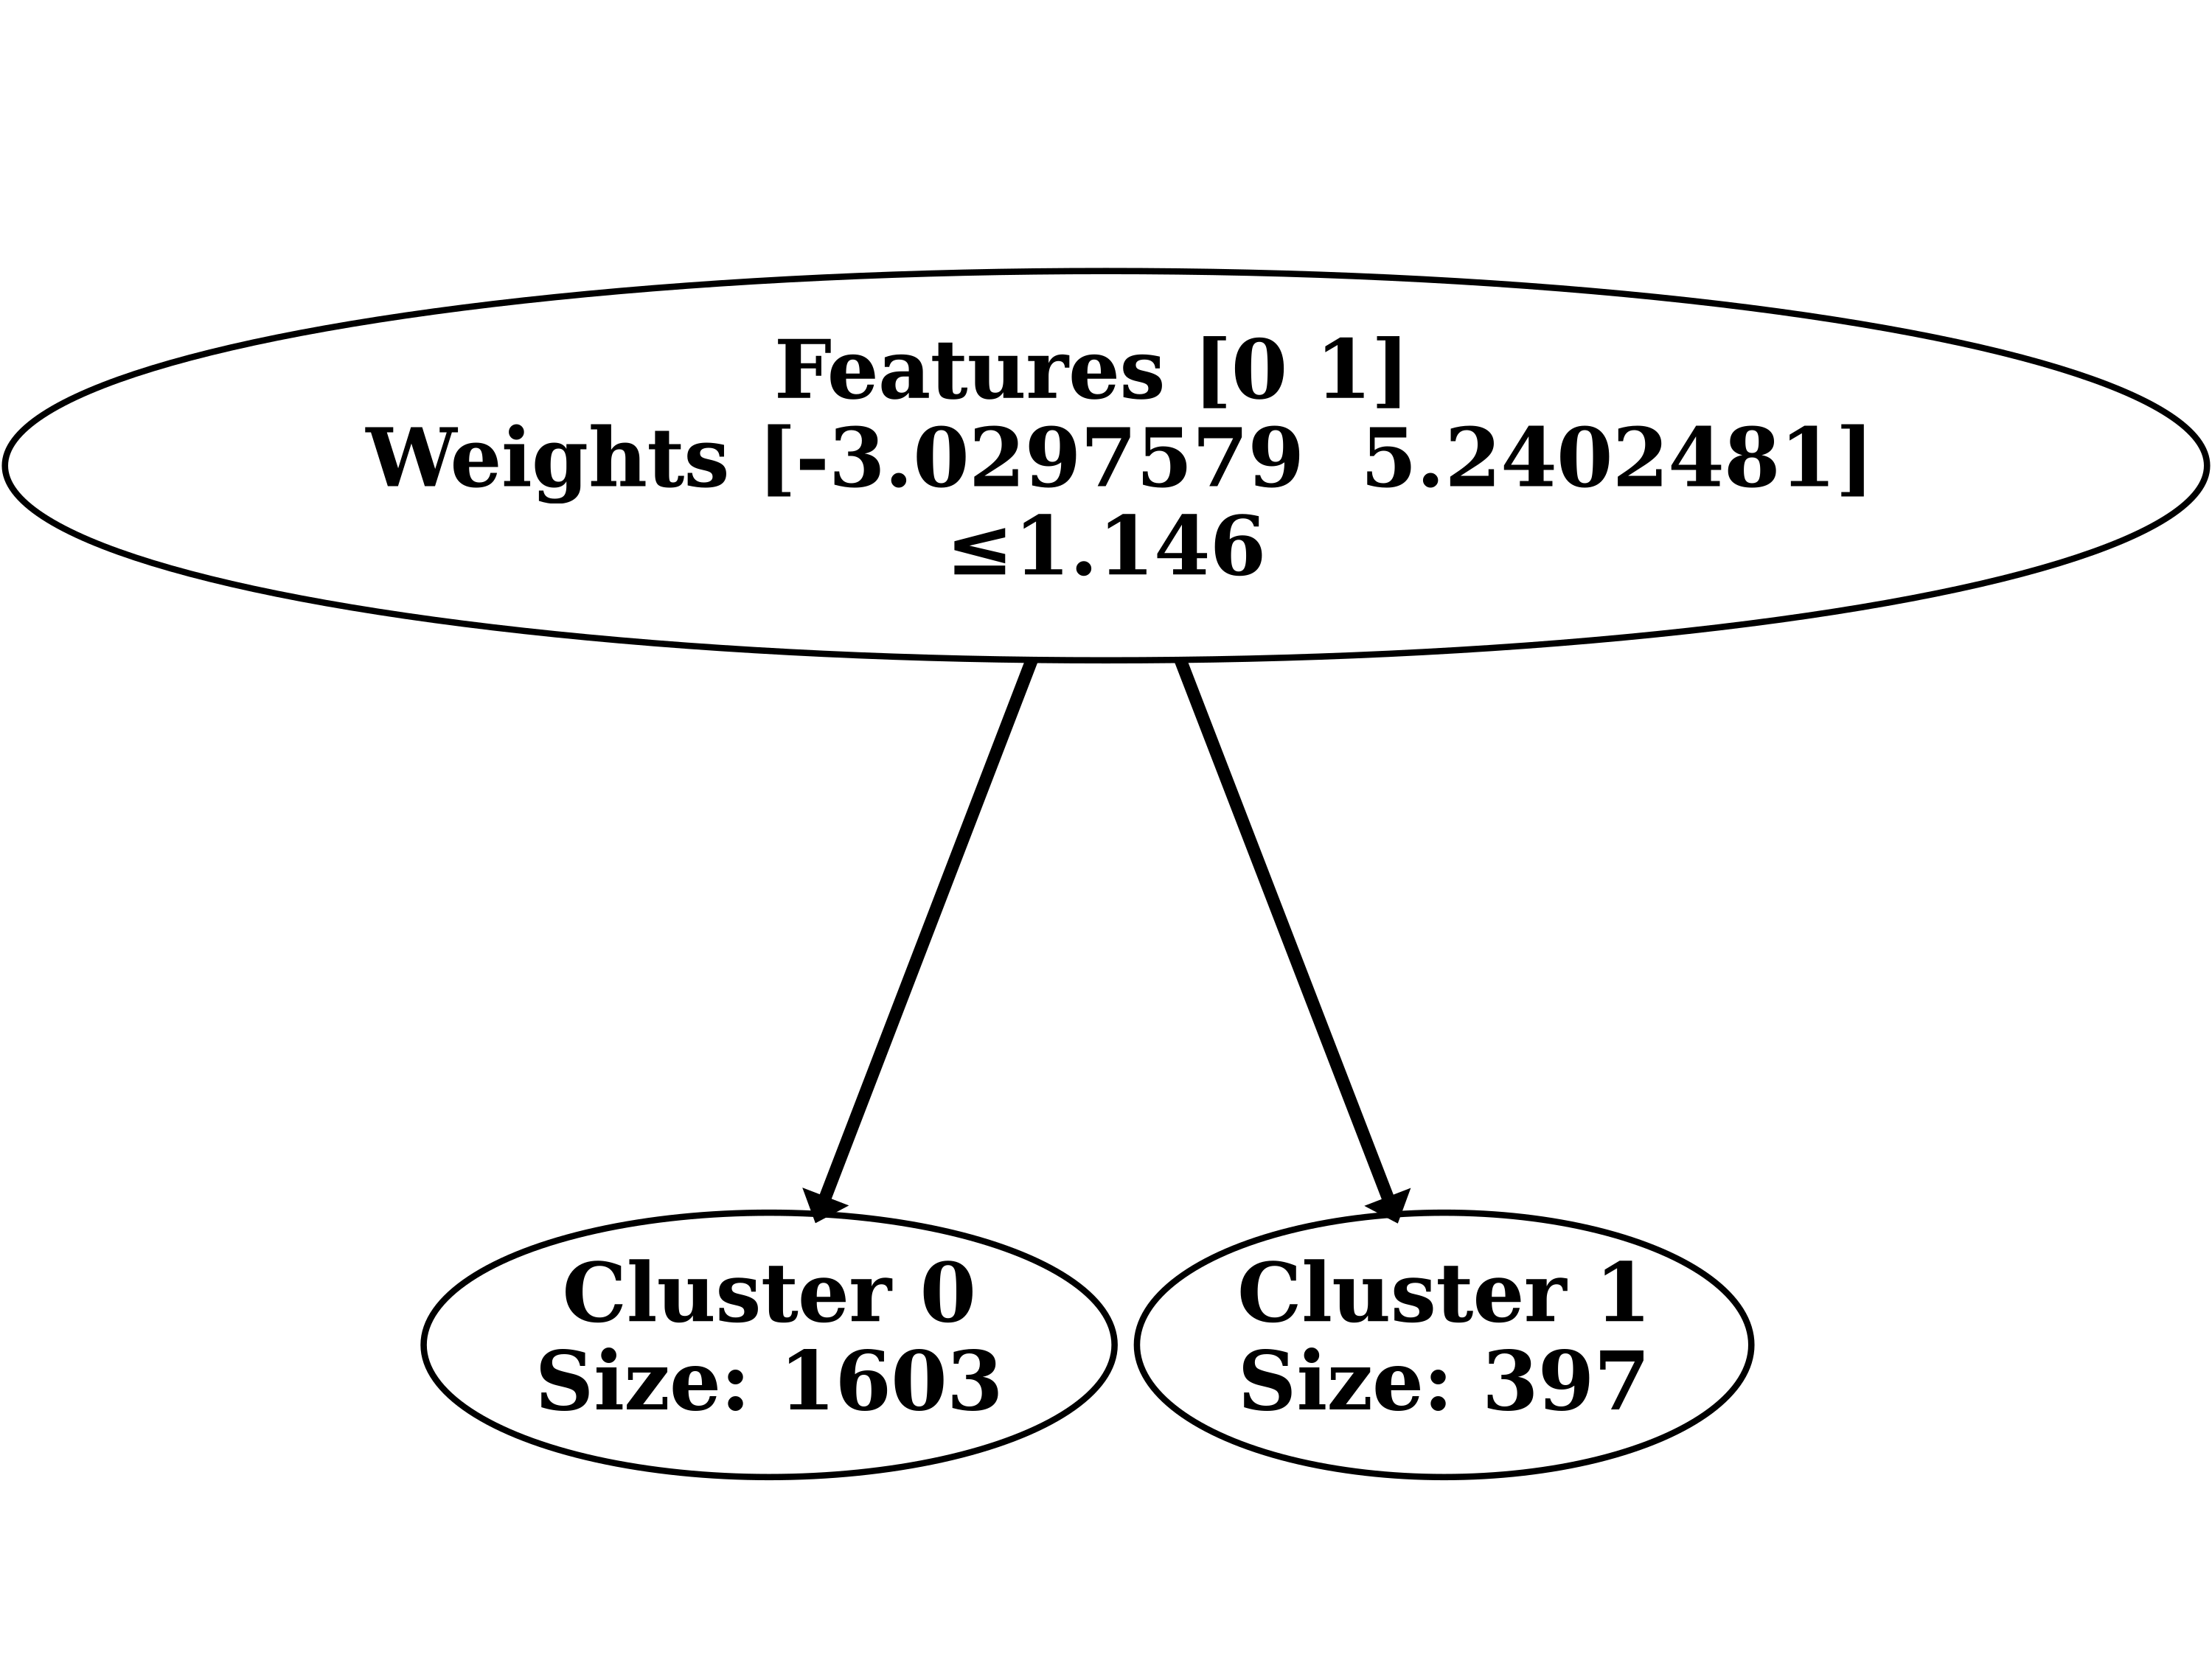

In [20]:
visualize_tree(svm_tree.root, cost = False)

In [42]:
from sklearn.svm import LinearSVC
y = (kmeans.labels_ == 2).astype(int)
#y = kmeans.labels_
svm = LinearSVC().fit(data, y)
svm_labels = svm.predict(data)

Text(0, 0.5, 'y')

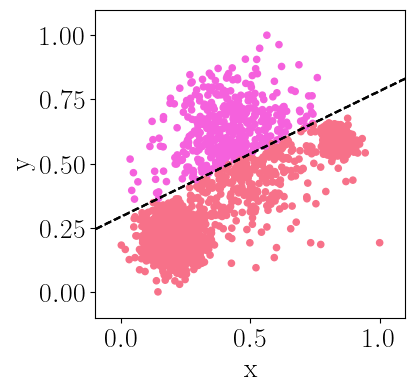

In [43]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[:,0], data[:,1], c = svm_labels, cmap = cmap, s = 20)
plot_decision_boundaries(svm, data, ax = ax, resolution = 1000)
ax.set_xlabel('x')
ax.set_ylabel('y')

In [44]:
sub_data = data[np.where(svm_labels == 0)[0],:]
sub_y = y[np.where(svm_labels == 0)[0]]
#sub_y = (kmeans.labels_ == 1).astype(int)[np.where(svm_labels == 0)[0]]
sub_svm = LinearSVC().fit(sub_data, sub_y)
sub_svm_labels = svm.predict(sub_data)

Text(0, 0.5, 'y')

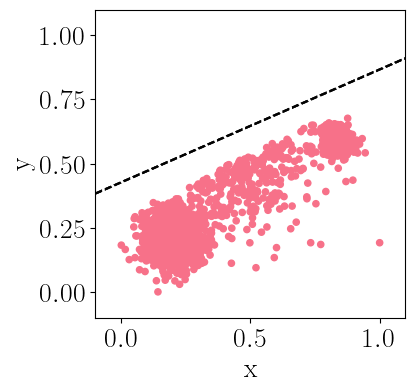

In [45]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(sub_data[:,0], sub_data[:,1], c = sub_svm_labels, cmap = cmap, s = 20)
plot_decision_boundaries(sub_svm, data, ax = ax, resolution = 1000)
ax.set_xlabel('x')
ax.set_ylabel('y')

## Decision Forest

In [174]:
np.random.seed(918713)

In [74]:
feature_pairings = [[0, 1]]

forest_tree_params = {
    'max_depth' : 3
}

forest = DecisionForest(
    SklearnTree,
    tree_params = forest_tree_params, 
    num_trees = 10,
    max_features = 2,
    max_labels = 1,
    feature_pairings = feature_pairings, 
    train_size = 0.75
)

data_labels = labels_format(kmeans.labels_)
forest.fit(data, data_labels)

In [175]:
forest_tree_params_exkmc = {
    'k' : k,
    'kmeans' : kmeans,
    'max_leaf_nodes' : 6,
    'imm' : True
}

forest_params_exkmc = {
    'tree_model' : ExkmcTree,
    'tree_params' : forest_tree_params_exkmc,
    'num_trees' : 1,
    'max_features' : 2,
    'max_labels' : k,
    'feature_pairings' : [[0,1]],
    'train_size' : 1
}

forest = DecisionForest(**forest_params_exkmc)
forest.fit(data, data_labels)

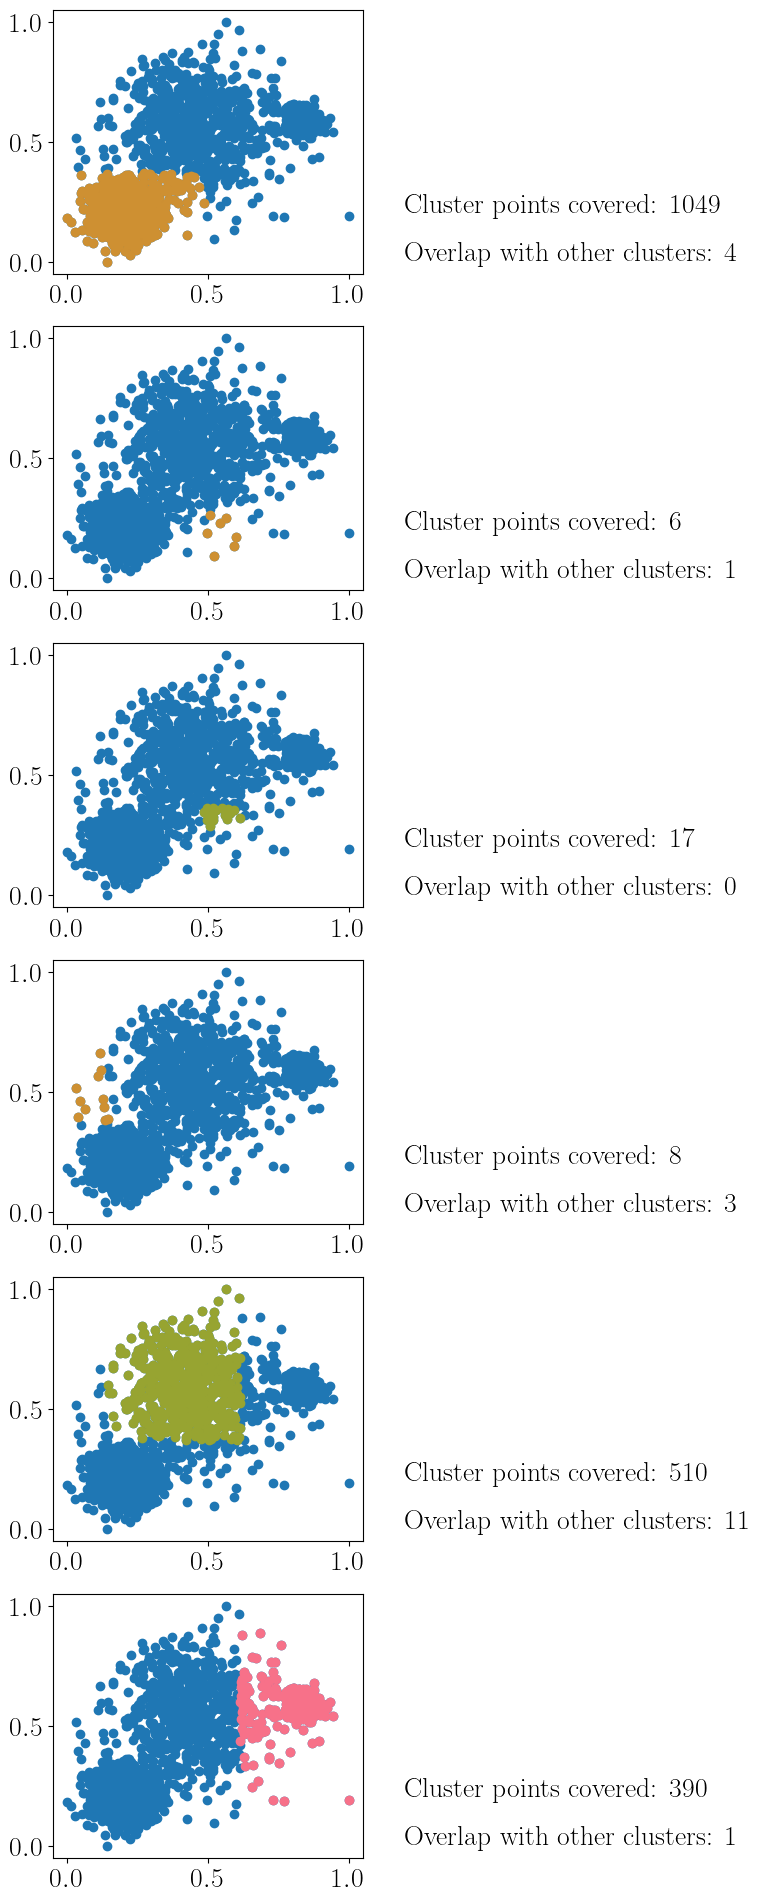

In [176]:
# Visualize points satisfied by each rule
ld = len(forest.decision_set)
fig, ax = plt.subplots(ld, 1, figsize = (4,4 * ld))

for i, condition_list in enumerate(forest.decision_set):
    r_label = list(forest.decision_set_labels[i])[0]
    indices = satisfies_conditions(data, condition_list)
    ax[i].scatter(data[:, 0], data[:, 1])
    ax[i].scatter(data[indices, 0], data[indices, 1], color = cmap(r_label))
    points_covered = np.sum(kmeans.labels_[indices] == r_label)
    n_overlaps = len(indices) - np.sum(kmeans.labels_[indices] == r_label)
    ax[i].text(x = 1.2, y = 0.2, s = "Cluster points covered: " + str(points_covered), ha = 'left')
    ax[i].text(x = 1.2, y = 0, s = "Overlap with other clusters: " + str(n_overlaps), ha = 'left')

In [172]:
prune_objective = KmeansObjective(
    X = data,
    centers = kmeans.cluster_centers_,
    average = False,
    normalize = True
)

forest.prune(
    n_rules = 3,
    frac_cover = 0.9,
    n_clusters = 3,
    X = data, 
    y = labels_format(kmeans.labels_),
    objective = prune_objective,
    lambda_search_range = np.linspace(0,10,101)
    
)
prune_predictions = forest.pruned_predict(data, rule_labels = False)

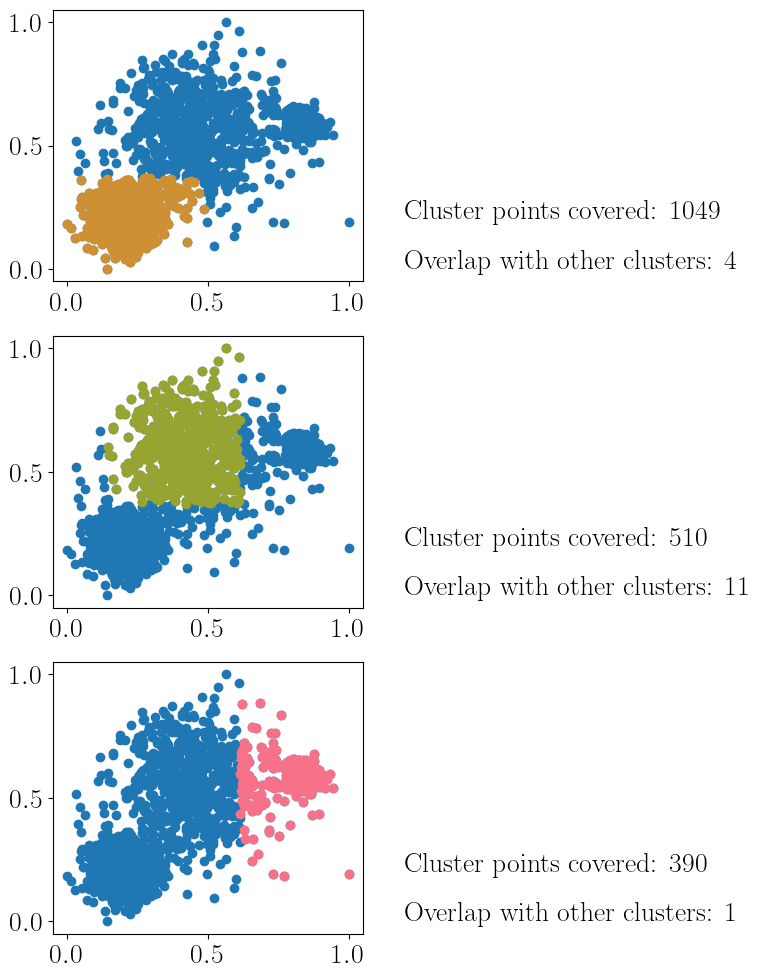

In [173]:
# Visualize rules chosen by pruning
pruned_decision_set = [forest.decision_set[i] for i in forest.pruned_indices]
pruned_decision_set_labels = [forest.decision_set_labels[i] for i in forest.pruned_indices]
#prune_label_array = flatten_labels(pruned_decision_set.labels)
ld = len(pruned_decision_set)
fig, ax = plt.subplots(ld, 1, figsize = (4,4 * ld))

for i, condition_list in enumerate(pruned_decision_set):
    r_label = list(forest.decision_set_labels[forest.pruned_indices[i]])[0]
    indices = satisfies_conditions(data, condition_list)
    points_covered = np.sum(kmeans.labels_[indices] == r_label)
    n_overlaps = len(indices) - np.sum(kmeans.labels_[indices] == r_label)
    if ld > 1:
        ax[i].scatter(data[:, 0], data[:, 1])
        ax[i].scatter(data[indices, 0], data[indices, 1], color = cmap(list(pruned_decision_set_labels[i])[0]))
        ax[i].text(x = 1.2, y = 0.2, s = "Cluster points covered: " + str(points_covered), ha = 'left')
        ax[i].text(x = 1.2, y = 0, s = "Overlap with other clusters: " + str(n_overlaps), ha = 'left')
    else:
        ax.scatter(data[:, 0], data[:, 1])
        ax.scatter(data[indices, 0], data[indices, 1], color = cmap(list(pruned_decision_set_labels[i])[0]))
        ax.text(x = 1.2, y = 0.2, s = "Cluster points covered: " + str(points_covered), ha = 'left')
        ax.text(x = 1.2, y = 0, s = "Overlap with other clusters: " + str(n_overlaps), ha = 'left')

In [96]:
[forest.decision_set[i] for i in forest.pruned_indices]

[[<intercluster.rules._conditions.LinearCondition at 0x7f941a997b80>,

In [97]:
'''
fname = None
cluster_colors = {i: cmap_subset(i) for i in range(k)}
plot_decision_set(
    [forest.decision_set[i] for i in forest.pruned_indices],
    ["0", "1"],
    [forest.decision_set_labels[i] for i in forest.pruned_indices],
    cluster_colors,
    filename = fname
)
'''

'\nfname = None\ncluster_colors = {i: cmap_subset(i) for i in range(k)}\nplot_decision_set(\n    [forest.decision_set[i] for i in forest.pruned_indices],\n    ["0", "1"],\n    [forest.decision_set_labels[i] for i in forest.pruned_indices],\n    cluster_colors,\n    filename = fname\n)\n'

## Voronoi Decision Sets

In [140]:
np.random.seed(919817)

In [141]:
centers = kmeans.cluster_centers_

In [151]:
vor = VoronoiSet(
    centers = centers, 
    num_sets = 10,
    num_conditions = 1,
    feature_pairings = [[0,1]]
)
data_labels = labels_format(kmeans.labels_)
vor.fit(data, data_labels)

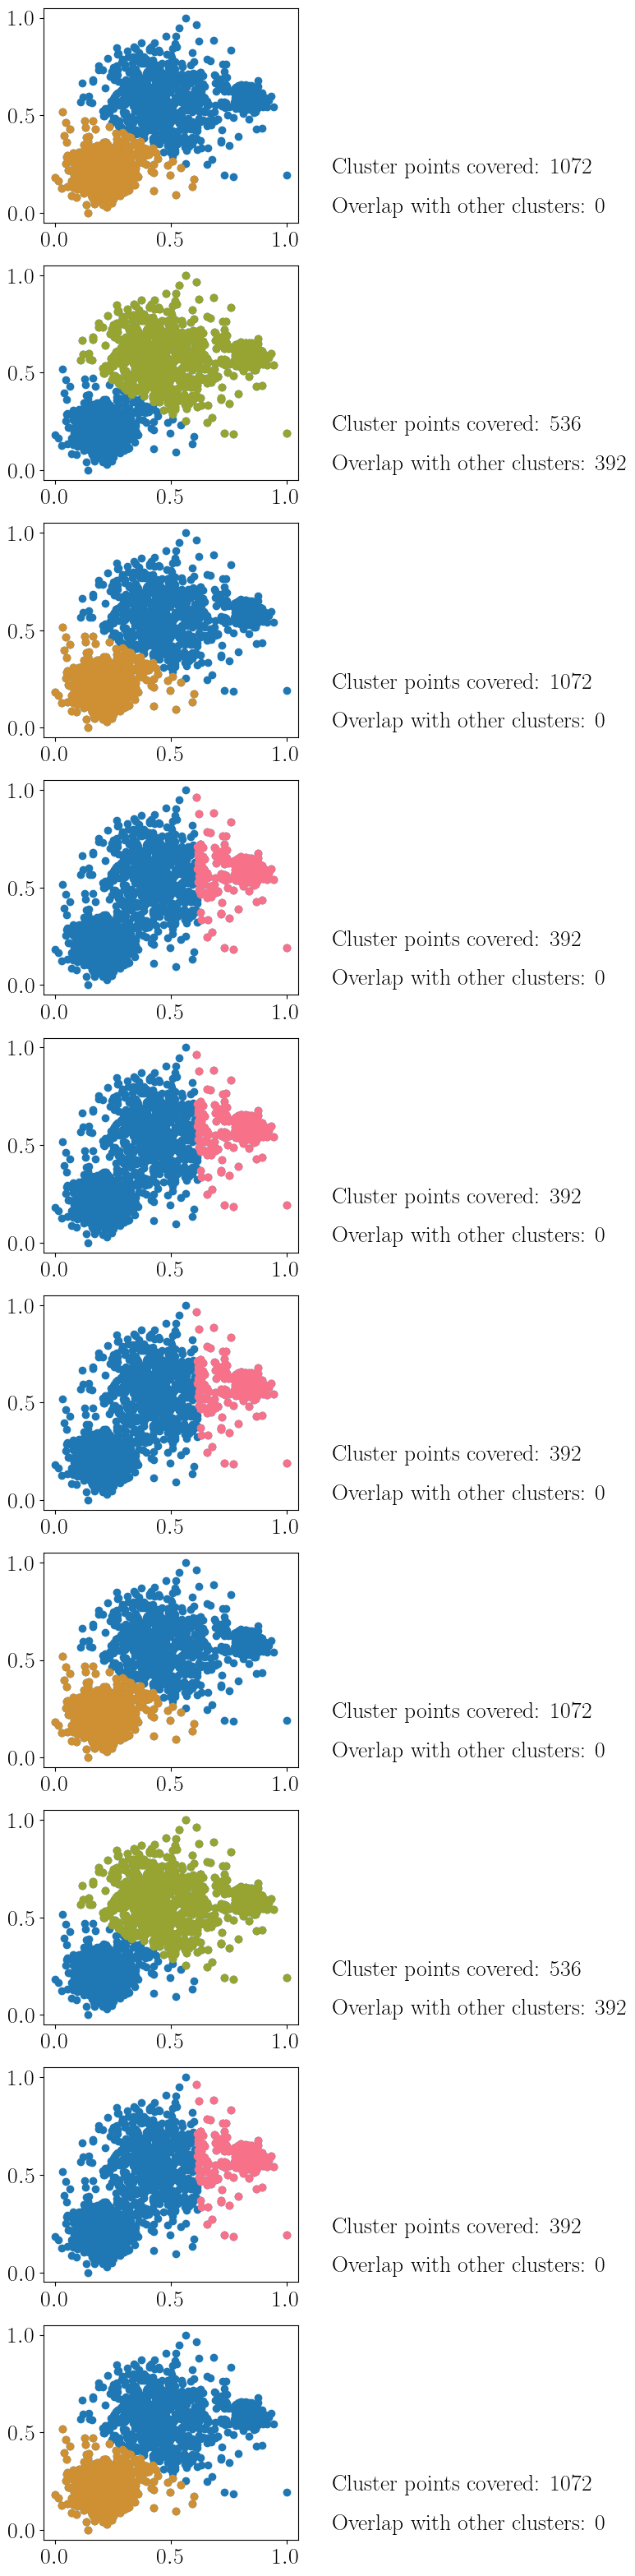

In [152]:
# Visualize points satisfied by each rule
ld = len(vor.decision_set)
fig, ax = plt.subplots(ld, 1, figsize = (4,4 * ld))

for i, cond_list in enumerate(vor.decision_set):
    r_label = vor.decision_set_labels[i][0]
    indices = satisfies_conditions(data, cond_list)
    ax[i].scatter(data[:, 0], data[:, 1])
    ax[i].scatter(data[indices, 0], data[indices, 1], color = cmap(r_label))
    points_covered = np.sum(kmeans.labels_[indices] == r_label)
    n_overlaps = len(indices) - np.sum(kmeans.labels_[indices] == r_label)
    ax[i].text(x = 1.2, y = 0.2, s = "Cluster points covered: " + str(points_covered), ha = 'left')
    ax[i].text(x = 1.2, y = 0, s = "Overlap with other clusters: " + str(n_overlaps), ha = 'left')

In [153]:
prune_objective = KmeansObjective(
    X = data,
    centers = kmeans.cluster_centers_,
    normalize = True
)

vor.prune(
    n_rules = 3,
    frac_cover = 0.5,
    n_clusters = 3,
    X = data, 
    y = [[l] for l in kmeans.labels_],
    objective = prune_objective,
    #lambda_search_range = np.linspace(0,100,101)
    lambda_search_range = [10]
)
prune_predictions = vor.pruned_predict(data, rule_labels = False)

In [154]:
vor.prune_status

True

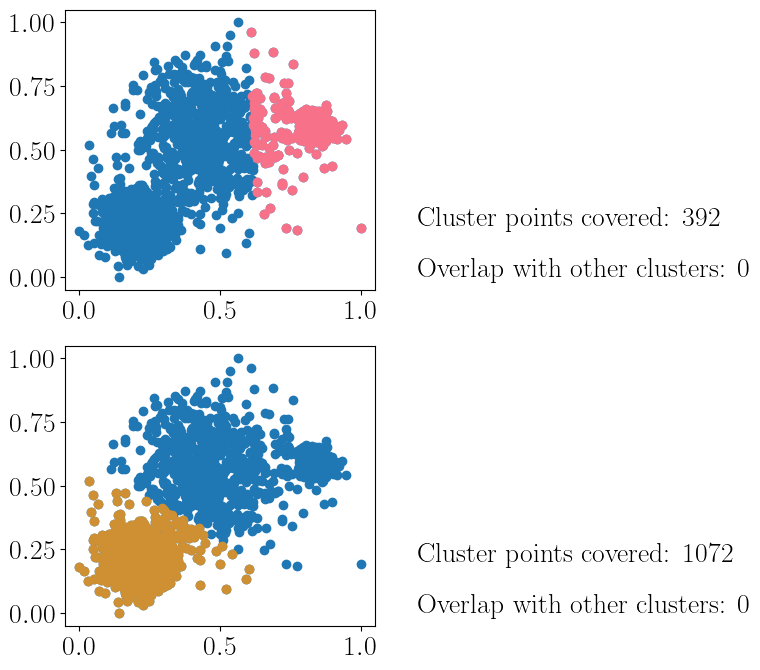

In [132]:
# Visualize rules chosen by pruning
pruned_decision_set = [vor.decision_set[i] for i in vor.pruned_indices]
pruned_decision_set_labels = [vor.decision_set_labels[i] for i in vor.pruned_indices]
ld = len(pruned_decision_set)
fig, ax = plt.subplots(ld, 1, figsize = (4,4 * ld))

for i, cond_list in enumerate(pruned_decision_set):
    r_label = vor.decision_set_labels[vor.pruned_indices[i]]
    indices = satisfies_conditions(data, cond_list)
    points_covered = np.sum(kmeans.labels_[indices] == r_label)
    n_overlaps = len(indices) - np.sum(kmeans.labels_[indices] == r_label)
    if ld > 1:
        ax[i].scatter(data[:, 0], data[:, 1])
        ax[i].scatter(data[indices, 0], data[indices, 1], color = cmap(pruned_decision_set_labels[i]))
        ax[i].text(x = 1.2, y = 0.2, s = "Cluster points covered: " + str(points_covered), ha = 'left')
        ax[i].text(x = 1.2, y = 0, s = "Overlap with other clusters: " + str(n_overlaps), ha = 'left')
    else:
        ax.scatter(data[:, 0], data[:, 1])
        ax.scatter(data[indices, 0], data[indices, 1], color = cmap(pruned_decision_set_labels[i]))
        ax.text(x = 1.2, y = 0.2, s = "Cluster points covered: " + str(points_covered), ha = 'left')
        ax.text(x = 1.2, y = 0, s = "Overlap with other clusters: " + str(n_overlaps), ha = 'left')